## Deep learning for predicting log returns for BTCUSD

In [6]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                # Binance market data utilities

In [7]:
research.set_seed(42)

In [8]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1) #Show all colums

polars.config.Config

#### Getting Data from Binance

##### Setting the data parameters

In [19]:
#Trading pair symbol
sym = "BTCUSDT"
#Historical data window in days (e.g., 6 months)
hist_data_window = 7*4*12 #Days, weeks, months
#time horizon of time series (time interval)
time_interval = "1h"
#max number of auto-regressive lags
max_lags = 4
#Forecast horizon
forecast_horizon = 1
#Sharpe annualzied rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval,365,24)

##### Download the data

In [ ]:
# binance.download_trades(sym, hist_data_window)

In [20]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 168/168 [00:29<00:00,  5.67file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-05-17 00:00:00,103412.2,103495.7,103036.1,103300.1
2025-05-17 01:00:00,103300.0,103300.1,102541.6,102778.4
2025-05-17 02:00:00,102778.4,103318.7,102699.7,103232.4
2025-05-17 03:00:00,103232.5,103564.7,103114.5,103464.7
2025-05-17 04:00:00,103464.6,103625.3,103415.2,103600.3
…,…,…,…,…
2025-10-31 19:00:00,109415.7,110231.0,109076.5,109802.8
2025-10-31 20:00:00,109802.7,109802.7,109405.2,109455.4
2025-10-31 21:00:00,109455.4,109718.7,109277.7,109530.1


In [21]:
research.load_timeseries(sym, time_interval, pl.col("price").quantile(0.5).alias("price_median"))

Loading BTCUSDT: 100%|██████████| 168/168 [00:32<00:00,  5.24file/s]


datetime,price_median
datetime[μs],f64
2025-05-17 00:00:00,103261.0
2025-05-17 01:00:00,102816.0
2025-05-17 02:00:00,103059.4
2025-05-17 03:00:00,103263.9
2025-05-17 04:00:00,103525.1
…,…
2025-10-31 19:00:00,109830.9
2025-10-31 20:00:00,109647.2
2025-10-31 21:00:00,109526.9


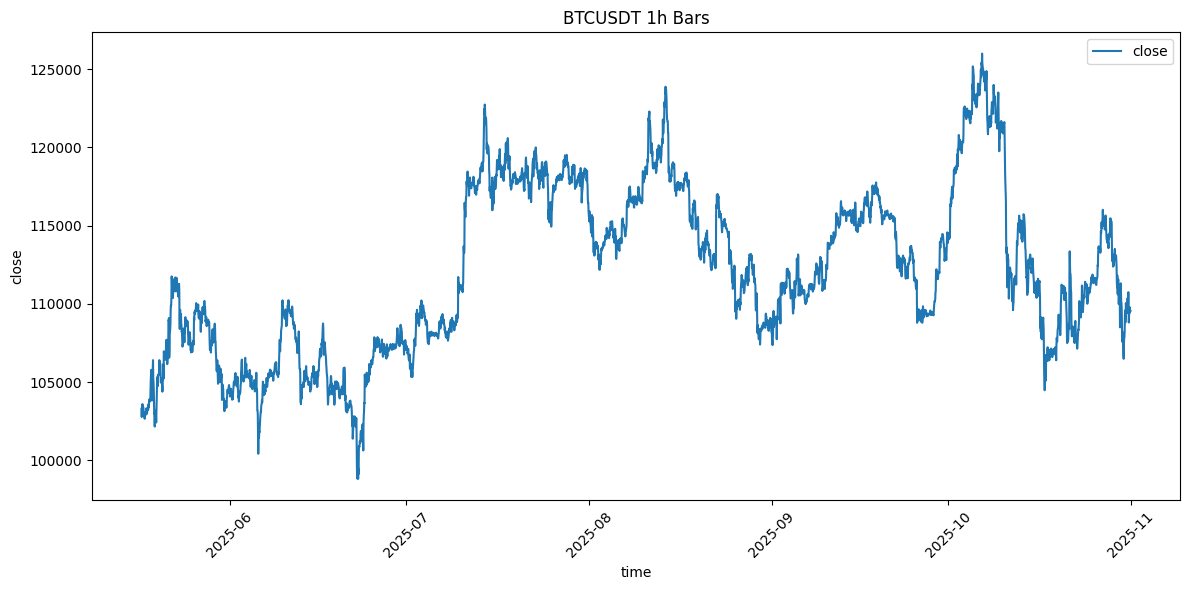

In [22]:
research.plot_static_timeseries(ts, sym, "close", time_interval)

In [23]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, "close", time_interval)

alt.Chart(...)

#### Feature Engineering